## Introduction

The purpose of this notebook is running K-Means clustering to see if the algorithm can sucessfully cluster the news in to 'Real' & 'Fake' using just the words in the articles

## Imports

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt #  plotting and data visualization
import seaborn as sns # improve visuals
sns.set() # Set as default style

import string # python library
import re # regex library

from gensim.parsing.preprocessing import preprocess_string, strip_tags, strip_punctuation, strip_multiple_whitespaces, strip_numeric, remove_stopwords, strip_short # Preprocesssing
from gensim.models import Word2Vec # Word2vec

from sklearn import cluster # Kmeans clustering
from sklearn import metrics # Metrics for evaluation
from sklearn.decomposition import PCA #PCA
from sklearn.manifold import TSNE #TSNE

## Data Analysis & Cleanup

In [2]:
import pandas as pd
import io
from google.colab import files

In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rakibulshezan","key":"d6956859467d11693eb8f842bd380125"}'}

In [4]:
url = 'https://raw.githubusercontent.com/lutzhamel/fake-news/master/data/fake_or_real_news.csv'

In [5]:
final_data = pd.read_csv(url)

In [6]:
final_data.head()

id  ... label
0   8476  ...  FAKE
1  10294  ...  FAKE
2   3608  ...  REAL
3  10142  ...  FAKE
4    875  ...  REAL

[5 rows x 4 columns]

# ***Replace label with numeric values*** **bold text**

In [7]:
final_data = final_data.replace(to_replace ="FAKE",
                 value =0)



In [8]:
final_data = final_data.replace(to_replace ="REAL",
                 value =1)


Some of the text still contains various characters/words such as:

1. Links
2. Timestamps
3. Brackets
4. Numbers

So we will be removing all such characters from the real and fake data using genlib preprocessing and a custom regex for the links in preperation for the Word2Vec

Before that however, the title and text will be merged in to one so that it can all be preprocessed together. I will also add a label for real and fake which will be used later to evaluate our clustering

In [9]:
# Merging title and text
final_data['text'] = final_data['title'] + ' ' + final_data['text']

# Randomize the rows so its all mixed up
final_data = final_data.sample(frac=1).reset_index(drop=True)

# Drop columns not needed
final_data = final_data.drop(['id', 'title'], axis = 1)

final_data.head(10)

text  label
0  Lester Holt: presidential debate moderator and...      1
1  Libertarian Party VP insults Trump, practicall...      0
2  A whirlwind day in D.C. showcases Trump’s unor...      1
3  The problem with Cruz and Kasich aligning to s...      1
4  The right turns on Paul Ryan: Yesterday’s cons...      1
5  Report from the Refugee Camp in Calais, France...      0
6  Marines’ killer set off no red flags [Read the...      1
7  BRINK OF WAR: UK sends TANKS, DRONES and 800 S...      0
8  It’s Cruz, not Trump, who looks more like favo...      1
9  Republican Lawmaker Secretly Recorded Fantasiz...      0

In [10]:
# Here we preprocess the sentences
def remove_URL(s):
    regex = re.compile(r'https?://\S+|www\.\S+|bit\.ly\S+')
    return regex.sub(r'',s)

# Preprocessing functions to remove lowercase, links, whitespace, tags, numbers, punctuation, strip words
CUSTOM_FILTERS = [lambda x: x.lower(), strip_tags, remove_URL, strip_punctuation, strip_multiple_whitespaces, strip_numeric, remove_stopwords, strip_short]

# Here we store the processed sentences and their label
processed_data = []
processed_labels = []

for index, row in final_data.iterrows():
    words_broken_up = preprocess_string(row['text'], CUSTOM_FILTERS)
    # This eliminates any fields that may be blank after preprocessing
    if len(words_broken_up) > 0:
        processed_data.append(words_broken_up)
        processed_labels.append(row['label'])

## Word2Vec

In [11]:
# Word2Vec model trained on processed data
model = Word2Vec(processed_data, min_count=1)

In [12]:
model.wv.most_similar("mother")

[('son', 0.9106370806694031),
 ('father', 0.9045554399490356),
 ('daughter', 0.8787648677825928),
 ('mom', 0.8730711340904236),
 ('daughters', 0.8678769469261169),
 ('boy', 0.8584601283073425),
 ('sister', 0.852910578250885),
 ('girls', 0.8374946117401123),
 ('pram', 0.8355098962783813),
 ('dad', 0.8279263973236084)]

## Sentence Vectors

In [13]:
# Getting the vector of a sentence based on average of all the word vectors in the sentence
# We get the average as this accounts for different sentence lengths

def ReturnVector(x):
    try:
        return model[x]
    except:
        return np.zeros(100)
    
def Sentence_Vector(sentence):
    word_vectors = list(map(lambda x: ReturnVector(x), sentence))
    return np.average(word_vectors, axis=0).tolist()

X = []
for data_x in processed_data:
    X.append(Sentence_Vector(data_x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [14]:
X_np = np.array(X)
X_np.shape

(6335, 100)

## Clustering

In [15]:
# Training for 2 clusters (Fake and Real)
kmeans = cluster.KMeans(n_clusters=2, verbose=1)

# Fit predict will return labels
clustered = kmeans.fit_predict(X_np)

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 24425.95600636972
start iteration
done sorting
end inner loop
Iteration 1, inertia 23668.29193872645
start iteration
done sorting
end inner loop
Iteration 2, inertia 23489.285416101167
start iteration
done sorting
end inner loop
Iteration 3, inertia 23427.93113325578
start iteration
done sorting
end inner loop
Iteration 4, inertia 23400.73124826886
start iteration
done sorting
end inner loop
Iteration 5, inertia 23387.543385883484
start iteration
done sorting
end inner loop
Iteration 6, inertia 23381.27150236867
start iteration
done sorting
end inner loop
Iteration 7, inertia 23377.571242657043
start iteration
done sorting
end inner loop
Iteration 8, inertia 23374.299000366686
start iteration
done sorting
end inner loop
Iteration 9, inertia 23372.289007784446
start iteration
done sorting
end inner loop
Iteration 10, inertia 23370.669269547943
start iteration
done sorting
end inner loop
Iteration 11

In [16]:
testing_df = {'Sentence': processed_data, 'Labels': processed_labels, 'Prediction': clustered}
testing_df = pd.DataFrame(data=testing_df)

testing_df.head(10)

Sentence  Labels  Prediction
0  [lester, holt, presidential, debate, moderator...       1           1
1  [libertarian, party, insults, trump, practical...       0           1
2  [whirlwind, day, showcases, trump’s, unorthodo...       1           1
3  [problem, cruz, kasich, aligning, stop, donald...       1           1
4  [right, turns, paul, ryan, yesterday’s, conser...       1           1
5  [report, refugee, camp, calais, france, “the, ...       0           0
6  [marines’, killer, set, red, flags, read, late...       1           0
7  [brink, war, sends, tanks, drones, soldiers, r...       0           0
8  [it’s, cruz, trump, looks, like, favorite, win...       1           1
9  [republican, lawmaker, secretly, recorded, fan...       0           1

The results above show that its correctly clustered them in some cases where 0 is fake news and 1 is real news

In [18]:
correct = 0
incorrect = 0
for index, row in testing_df.iterrows():
    if row['Labels'] == row['Prediction']:
        correct += 1
    else:
        incorrect += 1
        
print("Correctly clustered news: " + str((correct*100)/(correct+incorrect)) + "%")

Correctly clustered news: 66.34569850039463%


## Visualization

In [19]:
# PCA of sentence vectors
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_np)

PCA_df = pd.DataFrame(pca_result)
PCA_df['cluster'] = clustered
PCA_df.columns = ['x1','x2','cluster']

In [20]:
# T-SNE
tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(pca_result)

TSNE_df = pd.DataFrame(tsne_result)
TSNE_df['cluster'] = clustered
TSNE_df.columns = ['x1','x2','cluster']

Text(0.5, 1.0, 'Visualized on PCA')

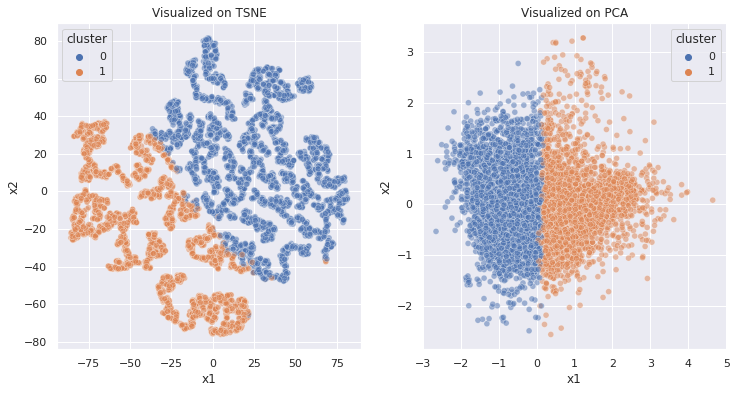

In [21]:
# Plots
fig, ax = plt.subplots(1, 2, figsize=(12,6))
sns.scatterplot(data=PCA_df,x='x1',y='x2',hue='cluster',legend="full",alpha=0.5,ax=ax[1])
sns.scatterplot(data=TSNE_df,x='x1',y='x2',hue='cluster',legend="full",alpha=0.5,ax=ax[0])
ax[0].set_title('Visualized on TSNE')
ax[1].set_title('Visualized on PCA')

## Custom News Tests

In [ ]:
# Testing with fake news generated from https://www.thefakenewsgenerator.com/
onion_data = "On Thursday in the Afternoon, William Anderton , Printer , was brought to the Bar, and an Indictment of High-Treason was read against him; for that he did Compose, Print and publish Two Malicious, Scandalous and Traitorous Libels, The first Entitled, Remarks upon the present Confederacy, and late Revolution in England. The second Entitled, A French Conquest neither desirable, nor practicable."

# Preprocess article
onion_data = preprocess_string(onion_data, CUSTOM_FILTERS)

# Get sentence vector
onion_data = Sentence_Vector(onion_data)

# Get prediction
kmeans.predict(np.array([onion_data]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


array([0], dtype=int32)

In [ ]:
# News from BBC

bbc_data = "Nasa Mars 2020 Mission's MiMi Aung on women in space Next year, Nasa will send a mission to Mars. The woman in charge of making the helicopter that will be sent there – which is set to become the first aircraft to fly on another planet – is MiMi Aung. At 16, MiMi travelled alone from Myanmar to the US for access to education. She is now one of the lead engineers at Nasa. We find out what it's like being a woman in space exploration, and why her mum is her biggest inspiration."

# Preprocess article
bbc_data = preprocess_string(bbc_data, CUSTOM_FILTERS)

# Get sentence vector
bbc_data = Sentence_Vector(bbc_data)

# Get prediction
kmeans.predict(np.array([bbc_data]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


array([1], dtype=int32)